# Final Assignment

Nitzan Ron, ID 215451709

Adam Zelzer, ID 328489166

## Preprocess Dataset

### Import Libraries

In [5]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
seed = 34
random.seed(seed)
np.random.seed(seed)

### Read Dataset

In [14]:
path_to_data = "review_230k.parquet"
data = pd.read_parquet(path_to_data)

In [15]:
def create_dataset(data: pd.DataFrame) -> List[str]:
    """ Creates a list of strings, where the title and text are joined together """
    # Convert to list
    return (data["title"] + " " + data["text"]).rename("text").tolist()

In [16]:
dataset = create_dataset(data)

### Clean and Standardize Data

In [17]:
# Example for text not in english
data.iloc[6420]

,6420
title,アストロドーム
text,研修でここに泊まりました。\n近くには名前のとおりアストロドームがあります。\n目の前には大...


In [18]:
import re

# Regular expression for non-English characters
# The characters in the pattern are commonly found in English text
NON_ENGLISH_CHARS= r'[^a-zA-Z0-9\s,."\'!?;:«»()$%&*@#~+=<>`=/\[\]\-_{}|\\^`´~£€¥°•…–—‘’“”êéèáàçôòü®¶§©™♥\U0001F600-\U0001F64F]'
# Regular expression for unwanted characters
UNWANTED_CHARS = r"[^a-z0-9\s.!?;êéèáàçôòü]"


def is_english(text: str, non_english_chars) -> bool:
    """ Check if the text is likely in English """
    non_english_regex = re.compile(non_english_chars)
    return not bool(non_english_regex.search(text))

def lower_text(text: str) -> str:
    """ Convert the text to lowercase """
    return text.lower()

def remove_unwanted_chars(text: str, unwanted_chars: str) -> str:
    """ Remove unwanted characters from the text """
    return re.sub(unwanted_chars, '', text)

def standardize_numbers(text: str) -> str:
    """ Remove unwanted letters after numbers """
    return re.sub(r'(\d+)([a-z]+)', r'\1', text)

def standardize_phrase(text: str, phrase_replacements: dict[str, str]) -> str:
    """ Replace common phrases with abbreviations """
    for phrase, replacement in phrase_replacements.items():
        text = text.replace(phrase, replacement)
    return text

def standardize_chracters(text: str, character_replacements: dict[str, str]) -> str:
    """ Replace accented characters"""
    for char, replacement in character_replacements.items():
        text = text.replace(char, replacement)
    return text

def remove_stop_words(text: str, stop_words: List[str]) -> str:
    """ Remove stop words from the text """
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    return pattern.sub('', text)

def standardize_spacing(text: str) -> str:
    """ Remove double padding from the text """
    return re.sub(r'\s+', ' ', text)

def sent_tokenize(text: str) -> List[str]:
    """ Tokenize the text into sentences """

    tokenized = re.split(r'\.+|\?+|\!+|\;+', text)

    tokenized_lst = []
    for i in range(len(tokenized)):
      if len(tokenized[i]) > 0:
        tokenized_lst.append(tokenized[i].strip())

    return tokenized_lst

def short_sentence(text: str, threshold: int) -> bool:
    """ Check if the sentence is short """
    return len(text.split()) < threshold


In [19]:
STOP_WORDS = [
    'who', 'why', 'which', 'where', 'when', 'what', 'while', 'how', 'if',
    'is', 'are', 'am', 'was', 'were', 'will', 'would', 'should', 'could',
    'does', 'do', 'did',
    'i', 'im', 'it', 'he', 'she', 'we', 'they', 'you', 'us', 'me',
    'his', 'her', 'its', 'our', 'your', 'youre', 'their', 'theirs', 'my', 'mine',
    'itself', 'myself', 'himself', 'herself', 'themselves', 'yourself', 'yourselves', 'ourselves',
    'these', 'theres', 'there', 'then',
    'has', 'have', 'had',
    'or', 'and', 'also', 'with', 'such', 'just',
    'because', 'but', 'about', 'than',
    'after', 'during', 'to', 'each', 'from', 'here', 'for', 'this', 'thats',
    'a', 'an', 'be', 'of', 'as', 'so', 'in', 'on', 'at',
    'through', 'other', 'only', 'both', 'that', 'the', 'can'
]

PHRASE_REPLACMENTS = {
          "new york": "ny", "newyork": "ny", "nyc": "ny" +" " +"city",
          "new jersey": "nj", "air conditioning": "ac",
          "cable tv": "tv", "television": "tv",
          "thank you": "thanks","internetwifi": "wifi",
          "wifii": "wifi", "hotell": "hotel",
          "tooo": "too", "toooo": "too", "manhatten": "manhattan", "manhatton": "manhattan",
          "confortable": "comfortable", "inroom": "in room", "anniverary": "anniversary",
          "resturaunt": "resturaunt", "\n": '', "\t": '', "not": "no",

          'isnt': "is no", 'arent': "are no", 'wasnt': "was no", 'werent': "were no",
          'wont': "will no", 'wouldnt': "would no", 'doesnt': "does no", 'dont': "do no",
          'didnt': "did no", 'shouldnt': "should no",'hasnt': "has no", 'havent': "have no",
          'hadnt': "had no", 'couldnt': "could no", 'aint': "is no", 'cant': "can no", 'mustnt': "must no",

          "two": "2", "three": "3", "four": "4", "five": "5",
          "six": "6", "seven": "7", "eight": "8", "nine": "9", "ten": "10",
          "twenty": "20", "thirty": "30", "forty": "40", "fifty": "50",
          "sixty": "60", "seventy": "70", "eighty": "80", "ninety": "90",
          "hundred": "100", "thousand": "1000"
         }

CHARACTER_REPLACMENTS = {
          'á': 'a', 'à': 'a',
          'ê': 'e', 'é': 'e', 'è': 'e',
          'ç': 'c',
          'ô': 'o', 'ò': 'o',
          'ü': 'u'
         }

In [20]:
from tqdm import tqdm

def prepare_dataset(dataset: List[str], threshold: int = 2) -> List[str]:
    """ Clean and prepare the dataset before word encoding """

    processed_dataset = []
    for text in tqdm(dataset):
      if is_english(text, NON_ENGLISH_CHARS):
         text = lower_text(text)
         text = remove_unwanted_chars(text, UNWANTED_CHARS)
         text = standardize_numbers(text)
         text = standardize_phrase(text, PHRASE_REPLACMENTS)
         text = standardize_chracters(text, CHARACTER_REPLACMENTS)
         text = remove_stop_words(text, STOP_WORDS)
         text = standardize_spacing(text)
         for sentence in sent_tokenize(text):
             if not short_sentence(sentence, threshold):
                processed_dataset.append(sentence.split(" "))

    return processed_dataset

prepared_dataset = prepare_dataset(dataset)

100%|██████████| 230339/230339 [01:27<00:00, 2644.24it/s]


### Create Vocabulary

In [21]:
VOCABULARY_SIZE = 15000 # Without <unk>
MIN_WORD_COUNT = 30

In [22]:
def filter_vocab(vocabulary: Dict[str, int], min_word_count: int = 30) -> Dict[str, int]:
    """ Filter the vocabulary based on the word frequency and the stop words list """

    filtered_vocab = {
                      word: count for word, count in vocabulary.items() if
                      count > min_word_count
                    }
    return filtered_vocab

def sort_dictionary_by_values(dictionary: Dict[str, int]) -> Dict[str, int]:
    """ Sort the dictionary by values in descending order """
    return dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

def create_word_count_vocabulary(dataset: List[List[str]], max_vocab_size: int,  min_word_count: int = 30) -> Dict[str, int]:
    """ Create a dictionary mapping each word to its respective frequency """
    word_count = {}
    for text in tqdm(dataset):
        for word in text:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    # Fliter the vocabulary by frequency by
    word_count = filter_vocab(word_count, min_word_count)

    # Sort the vocabulary by frequency in descending order
    word_count = sort_dictionary_by_values(word_count)

    # Limit the vocabulary size
    word_count = dict(list(word_count.items())[:max_vocab_size])

    return word_count

def create_vocabulary(word_count_vocabulary: Dict[str, int]) -> Dict[str, int]:
    """ Create a dictionary mapping each word to its respective frequency """

    # Create the vocabulary dictionary by giving each word a label
    vocabulary = {word: index for index, word in enumerate(word_count_vocabulary.keys())}
    vocabulary['<unk>'] = len(vocabulary)

    return vocabulary

In [23]:
WORD_COUNT_VOCABULARY = create_word_count_vocabulary(dataset = prepared_dataset, max_vocab_size = VOCABULARY_SIZE, min_word_count = MIN_WORD_COUNT)
WORD_COUNT = list(WORD_COUNT_VOCABULARY.values())
VOCABULARY = create_vocabulary(word_count_vocabulary = WORD_COUNT_VOCABULARY)
REVERSE_VOCABULARY = [word for word in VOCABULARY.keys()]

100%|██████████| 1992378/1992378 [00:06<00:00, 312836.39it/s]


### Save Vocabulary

In [32]:
import pyarrow
import pyarrow.parquet as pq

def save_vocabulary(vocabulary: List[str], path: str):
    """
    Save the vocabulary
    param: vocabulary: list of tokens
    param: path: the path to save the vocabulary
    """

    # Create a table from the vocabulary
    table = pyarrow.Table.from_pydict({'word': vocabulary.keys(), 'index': vocabulary.values()})

    # Save the table as a Parquet file
    pq.write_table(table, path)


def load_vocabulary(path: str):
    """
    Load the embeddings from a Parquet file.
    param path: the path to the Parquet file containing the vocabulary
    return: a dictionary mapping words to their corresponding index
    """
    # Read the table from the Parquet file
    table = pq.read_table(path)

    # Convert the table columns to lists
    words = table['word'].to_pylist()
    indeces = table['index'].to_pylist()

    # Create a dictionary mapping words to embeddings
    vocabulary = dict(zip(words, indeces))

    return vocabulary

save_vocabulary(VOCABULARY, 'vocabulary.parquet')

### Encode Dataset

In [ ]:
def encode_dataset(dataset: List[str], vocabulary: Dict[str, int]) -> List[List[int]]:
    """ Encode each word in the dataset, based on your vocabulary """

    # Get the unknown word index
    unknown_word_index = vocabulary.get('<unk>')

    # Encode the dataset
    encoded_dataset = [
        [
         vocabulary.get(word, unknown_word_index)
         for word in sentence
         ]
         for sentence in tqdm(dataset)
        ]

    return encoded_dataset

encoded_dataset = encode_dataset(prepared_dataset, VOCABULARY)

100%|██████████| 1992378/1992378 [00:11<00:00, 172202.51it/s]


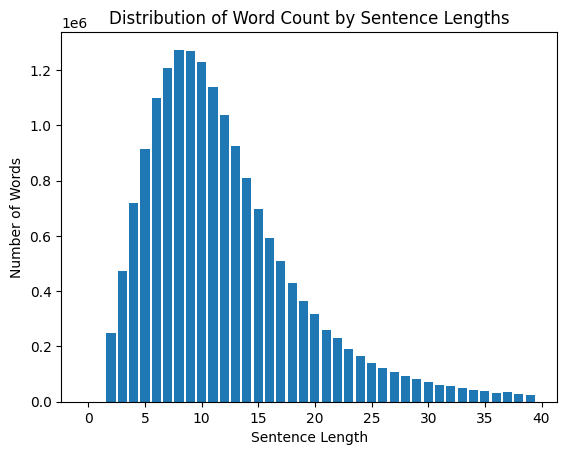

In [ ]:
max_length = 40
sentence_length = [0]*max_length
for lst in encoded_dataset:
    if len(lst) < max_length:
        sentence_length[len(lst)] += len(lst)

plt.bar(range(max_length), sentence_length)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Words')
plt.title('Distribution of Word Count by Sentence Lengths')
plt.show()

To improve on computation times, and make the dataset more regular, we'll limit ourself to a range of sentence lengths. We'll take just around the peak of the graph - 8.

In [ ]:
length_sentence_low, length_sentence_high = 7, 9
reduced_dataset = [lst for lst in encoded_dataset if (length_sentence_low <= len(lst) <= length_sentence_high)]
print(f"Number of words in final dataset: {sum([sentence_length[l] for l in range(length_sentence_low, length_sentence_high + 1)])}")

Number of words in final dataset: 3749686


### Generate Positive and Negative Pairs

First - We'll calculate the unigram distribution, which is based on word frequency, and use it to calculate positive and negative subsampling distributions.

In [ ]:
def calculate_unigram_distribution(word_count: List[int]) -> List[float]:
    """Calculate the unigram distribution U(w)"""
    total_count = sum(word_count)
    unigram_distribution = [count/total_count for count in word_count]
    return unigram_distribution

def positive_subsampling_probabilities(unigram_distribution: List[float],  threshold: float = 1e-5) -> List[float]:
    """ Calculate the positive subsampling distribution, as implemented in the C source code """
    return [(1+np.sqrt(frequency/threshold))*(threshold/frequency) for frequency in unigram_distribution]

def negative_subsampling_probabilities(unigram_distribution: List[float], negative_probabilities_range: int) -> List[float]:
    """ Adjust the unigram distribution by raising it to the 3/4th power, like the word2vec paper authors suggest """

    # Without <unk> token probability
    neg_subsample_probabilities = [prob ** 0.75 for prob in unigram_distribution][1:negative_probabilities_range+1]
    total_adjusted = sum(neg_subsample_probabilities)
    neg_subsample_probabilities = [prob / total_adjusted for prob in neg_subsample_probabilities]
    return neg_subsample_probabilities


We'll use these distributions to create positive and negative samples.

In [ ]:
def generate_sequence_positive_pairs(sequence: List[int],
                            context_window: int,
                            subsampling_probabilities: List[float],
                            vocabulary_size: int) \
                            -> List[Tuple[int]]:
    """Generate positive (target, context) pairs from the encoded dataset."""
    positive_pairs = []

    for i, word_index in enumerate(sequence):
      # Check if word is in vocabulary
      if word_index < vocabulary_size:
        if subsampling_probabilities[word_index] >= random.random():

            # Define context window boundaries
            window_start = max(0, i - context_window)
            window_end = min(len(sequence), i + context_window + 1)

            for j in range(window_start, window_end):
                if i != j and sequence[j] != vocabulary_size:  # Skip the target word itself and <unk>
                    positive_pairs.append((word_index, sequence[j]))

    return positive_pairs

def generate_negative_samples(number_of_neg_samples: int, context: int, negative_subsample_probabilities: List[float]) -> List[int]:
    """Generate negative samples for a given positive pair."""
    negative_probabilities_range = len(negative_subsample_probabilities)
    negative_samples = []
    while len(negative_samples) < number_of_neg_samples:
        negative_sample = np.random.choice(negative_probabilities_range, p = negative_subsample_probabilities) + 1
        if negative_sample != context:
            negative_samples.append(negative_sample)
    return negative_samples

In [ ]:
def generate_training_data(encoded_dataset: List[List[int]],
                           subsampling_probabilities: List[float],
                           negative_subsampling_probabilities: List[float],
                           vocabulary_size: int,
                           context_window: int,
                           number_of_neg_samples: int) \
                           -> Tuple[List[int], List[List[int]], List[List[int]]]:
    """
    Generates three arrays:
    targets: target words
    contexts: context words
    labels: labels for the positive and negative samples
    """

    # Each label consists of one positive sample and number_of_negative_samples negative samples
    label = [1] + [0]*number_of_neg_samples

    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []
    for sequence in tqdm(encoded_dataset):

        positive_pairs = generate_sequence_positive_pairs(sequence, context_window, subsampling_probabilities, vocabulary_size)

        for target_word, context_word in positive_pairs:

            negative_samples = generate_negative_samples(number_of_neg_samples, context_word, negative_subsampling_probabilities)


            # Build context and label vectors (for one target word)
            context = [context_word] + negative_samples

            # Append each element from the training example to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return np.array(targets), np.array(contexts), np.array(labels)

According to the authors findings, for large datasets a low number of negative samples (2-5) is sufficient. In addition, since we removes stop words, the context window is decreased from 5, as the original paper suggests, to 2.

In [ ]:
CONTEXT_WINDOW=3
NUMBER_OF_NEG_SAMPLES=4
UNIGRAM_DISTRIBUTION = calculate_unigram_distribution(WORD_COUNT)
POSITIVE_SUBSAMPLING_PROBABILITIES = positive_subsampling_probabilities(UNIGRAM_DISTRIBUTION)
NEGATIVE_PROBABILITIES_RANGE = 1000 # Sample only from these words, to speed up computation
NEGATIVE_SUBSAMPLING_PROBABILITIES = negative_subsampling_probabilities(UNIGRAM_DISTRIBUTION, NEGATIVE_PROBABILITIES_RANGE)

targets, contexts, labels = generate_training_data(reduced_dataset,
                                                   POSITIVE_SUBSAMPLING_PROBABILITIES,
                                                   NEGATIVE_SUBSAMPLING_PROBABILITIES,
                                                   VOCABULARY_SIZE,
                                                   CONTEXT_WINDOW,
                                                   NUMBER_OF_NEG_SAMPLES)

100%|██████████| 472639/472639 [30:17<00:00, 260.02it/s]


In [ ]:
print('\n')
print(f"targets shape:\t {targets.shape}")
print(f"contexts shape:\t {contexts.shape}")
print(f"labels shape:\t {labels.shape}")



targets shape:	 (3708646,)
contexts shape:	 (3708646, 5)
labels shape:	 (3708646, 5)


## Model

### Define Model


In [2]:
from tensorflow.keras.layers import Embedding, Input, Reshape, Dot
from tensorflow.keras.models import Model

def Word2Vec(vocab_size, embedding_dim, n_negative_samples):

    # Define the inputs
    target_input = Input(shape=(1,), dtype=tf.int32, name='target_input')
    context_input = Input(shape=(n_negative_samples+1,), dtype=tf.int32, name='context_input')

    # Embedding layers
    target_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='target_embedding')
    context_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='context_embedding')

    # Embedding lookups
    target_vector = target_embedding(target_input)  # Shape: (batch_size, 1, embedding_dim)
    context_vectors = context_embedding(context_input)  # Shape: (batch_size, num_negative_samples+1, embedding_dim)

    # Compute the dot product between target and context vectors
    dot_product = Dot(axes=-1)([context_vectors, target_vector])  # Shape: (batch_size, num_negative_samples+1)

    # Define the model
    model = Model(inputs=[target_input, context_input], outputs=dot_product, name = "Word2Vec")

    return model

In [ ]:
EMBEDDING_DIMENSION = 128

word2vec = Word2Vec(vocab_size=VOCABULARY_SIZE, embedding_dim=EMBEDDING_DIMENSION, n_negative_samples=NUMBER_OF_NEG_SAMPLES)
word2vec.summary()

Model: "Word2Vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_embedding         │ (None, 5, 128)         │      1,920,000 │ context_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_embedding          │ (None, 1, 128)         │      1,920,000 │ target_input[0][0]     │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 5, 1)           │              0 │ context_embedding[0][… │
│                           │                        │                │ target_embedding[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,840,000 (14.65 MB)

 Trainable params: 3,840,000 (14.65 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
from sklearn.model_selection import train_test_split

targets_train, targets_val, contexts_train, contexts_val, labels_train, labels_val = train_test_split(targets, contexts, labels, test_size=0.33, random_state=seed)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

lr_adam = 1e-3
epochs = 20
patience = 5
batch_size = 1024

loss_fn = CategoricalCrossentropy(from_logits=True)

optimizer = Adam(lr_adam)

word2vec.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Add callbacks
tensorboard_callback = TensorBoard(log_dir="model_logs")
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

history = word2vec.fit(
    x=(targets_train, contexts_train),
    y=labels_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=((targets_val, contexts_val), labels_val),
    callbacks=[tensorboard_callback, early_stopping_cb]
)

Epoch 1/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 113s 46ms/step - accuracy: 0.8200 - loss: 1.3733 - val_accuracy: 0.8619 - val_loss: 0.8969
Epoch 2/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 146s 48ms/step - accuracy: 0.8637 - loss: 0.8500 - val_accuracy: 0.8647 - val_loss: 0.8428
Epoch 3/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 149s 50ms/step - accuracy: 0.8663 - loss: 0.7741 - val_accuracy: 0.8660 - val_loss: 0.8318
Epoch 4/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 127s 44ms/step - accuracy: 0.8680 - loss: 0.7261 - val_accuracy: 0.8669 - val_loss: 0.8346
Epoch 5/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 137s 42ms/step - accuracy: 0.8697 - loss: 0.6883 - val_accuracy: 0.8675 - val_loss: 0.8447
Epoch 6/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 143s 43ms/step - accuracy: 0.8713 - loss: 0.6575 - val_accuracy: 0.8679 - val_loss: 0.8594
Epoch 7/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 152s 47ms/step - accuracy: 0.8728 - loss: 0.6324 - val_accuracy: 0.8679 - val_loss: 0.8769
Epoch 8/20
2427/2427 ━━━━━━━━━━━━━━━━━━━━ 134s 43ms/step - accuracy: 

### Save Model

In [ ]:
word2vec.save(f"word2vec_model_w{CONTEXT_WINDOW}_ns{NUMBER_OF_NEG_SAMPLES}.keras", include_optimizer=True)

### Save Embeddings

The embedding are in fact the target weights.

In [35]:
import pyarrow
import pyarrow.parquet as pq

def save_embeddings(model: tf.keras.Model, vocabulary: List[str], path: str):
    """
    Save the embeddings
    param: model: the trained tf model
    param: vocabulary: list of tokens
    param: path: the path to save the embeddings map
    """
    # Extract the weights from the Word2Vec embedding layer
    weights = model.get_layer('target_embedding').get_weights()[0]

    # Create a dictionary mapping words to their corresponding embeddings
    embeddings_dict = {vocabulary[i]: weights[i] for i in range(len(vocabulary)-1)}

    # Convert the dictionary to a PyArrow table
    words = list(embeddings_dict.keys())
    embeddings = [embeddings_dict[word] for word in words]

    table = pyarrow.Table.from_pydict({'word': words, 'embedding': embeddings})

    # Save the table as a Parquet file
    pq.write_table(table, path)


def load_embeddings(path: str):
    """
    Load the embeddings from a Parquet file.
    param path: the path to the Parquet file containing the embeddings map
    return: a dictionary mapping words to their corresponding embeddings
    """
    # Read the table from the Parquet file
    table = pq.read_table(path)

    # Convert the table columns to lists
    words = table['word'].to_pylist()
    embeddings = table['embedding'].to_pylist()

    # Create a dictionary mapping words to embeddings
    embeddings_dict = dict(zip(words, embeddings))

    return embeddings_dict

save_embeddings(word2vec, REVERSE_VOCABULARY, 'word2vec_embeddings.parquet')
EMBEDDINGS = load_embeddings('word2vec_embeddings.parquet')

## Visualization

### TSNE

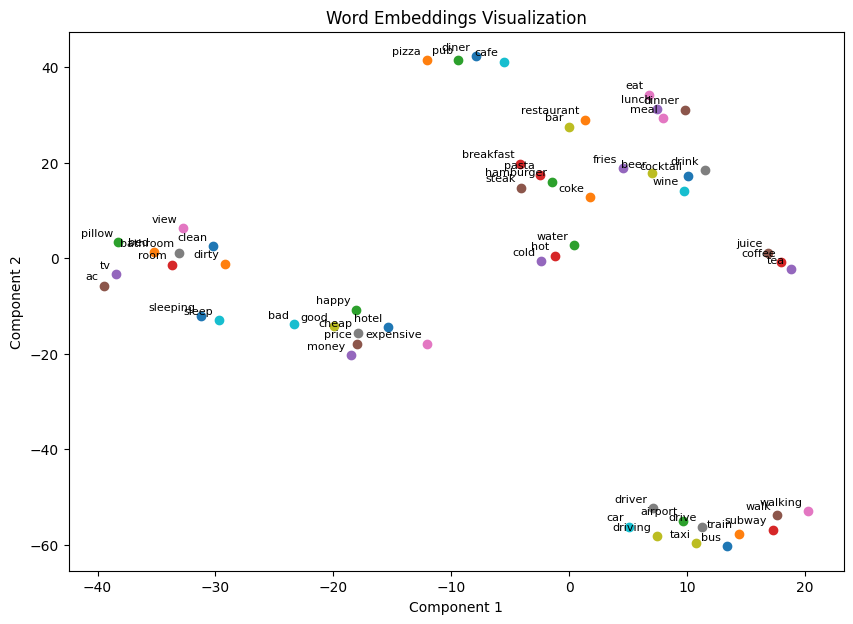

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

visualization_list = [
    "hotel", "bed", "pillow", "room", "tv", "ac", "view", "bathroom",
    "bar", "cafe", "diner", "restaurant", "pub",
    "breakfast", "lunch", "dinner", "meal",
    "driver", "taxi", "car", "bus", "train", "airport", "subway",
    "money", "price", "expensive", "cheap",
    "good", "bad", "clean", "dirty", "happy", "hot", "cold",
    "walk", "walking", "drive", "driving", "sleep", "sleeping",
    "pizza", "hamburger", "pasta", "fries", "steak", "eat",
    "drink", "beer", "wine", "cocktail", "coke", "water", "coffee", "tea", "juice"
]

def tsne_plot(visualization_list: List[str], embeddings: Dict[str, List[float]]):

    wordvecs = []

    for word in visualization_list:
        wordvecs.append(embeddings[word])

    wordvecs = np.array(wordvecs)

    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10,7))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(visualization_list[i],
                     xy=(x[i], y[i]),
                     xytext=(-4, 3),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=8)

    plt.title('Word Embeddings Visualization')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.show()

tsne_plot(visualization_list, EMBEDDINGS)


We can see very clear patterns and clusters!

### Dimentionality Reduction

visualize some clusters (pick some subset of words to show the labels for)

In [45]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import kneed
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

def dimentionality_reduction(visualization_list: List[str],
                             embeddings: Dict[str, List[float]],
                             vocabulary: Dict[str, int],
                             n_components: int,
                             seed: int) \
                              -> List[Tuple[float, float]]:
    """ Apply PCA to embeddings """
    emb_vectors = np.array([embeddings[word] for word in visualization_list])

    pca_model = PCA(n_components = n_components, random_state=seed)
    coordinates = pca_model.fit_transform(emb_vectors)

    return coordinates


def kmeans_best_k(visualization_list: List[str],
                             vocabulary: Dict[str, int],
                             embeddings: Dict[str, List[float]],
                             n_components: int,
                             seed: int,
                             k: Optional[int] = None):
    """ Kmeans clustering visualization """

    coordinates = dimentionality_reduction(visualization_list, embeddings, vocabulary, n_components, seed)

    if k is None:
      inertias=[]
      for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=seed)
        kmeans.fit(coordinates)
        inertias.append(kmeans.inertia_)

      kneedle = kneed.KneeLocator(range(1, 11), inertias, curve='convex', direction='decreasing', S=0.1)
      k = kneedle.knee

      # Elbow plot

      plt.figure(figsize=(10, 5))
      plt.plot(range(1, 11), inertias, "bo-")
      plt.xlabel("$k$", fontsize=14)
      plt.ylabel("Inertia", fontsize=14)
      plt.annotate('Elbow',
                  xy=(k, inertias[k-1]),
                  xytext=(0.55, 0.55),
                  textcoords='figure fraction',
                  fontsize=10,
                  arrowprops=dict(facecolor='black', shrink=0.05)
                  )

    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(coordinates)
    cluster_labels = kmeans.labels_

    plt.show()
    return coordinates, cluster_labels

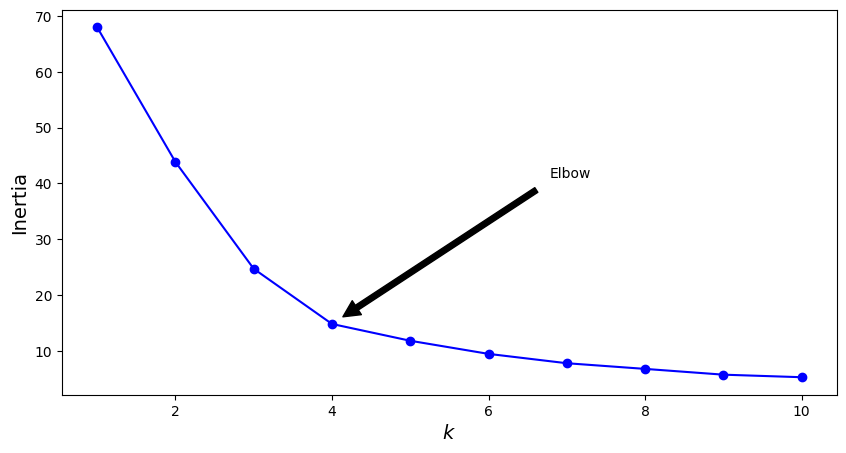

In [46]:
coordinates, cluster_labels = kmeans_best_k(visualization_list, vocabulary=VOCABULARY, embeddings=EMBEDDINGS, n_components = 3, seed=seed, k = None)

In [47]:
def plot_clusters(coordinates: List[Tuple[float]], cluster_labels: list[int], n_components: int = 3):
    if n_components == 3:

        x = [coord[0] for coord in coordinates]
        y = [coord[1] for coord in coordinates]
        z = [coord[2] for coord in coordinates]

        fig = px.scatter_3d(x=x, y=y, z=z,
                            color=cluster_labels,
                            text=visualization_list,
                            labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"})  # Create a 3D axes
        fig.show()

    elif n_components==2:

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        for i in range(len(coordinates)):
            x, y = coordinates[i][:2]  # Only take the first two components for 2D plotting
            plt.scatter(x, y, c=cluster_labels[i])
            plt.annotate(labels[i],
                         xy=(x, y),
                         xytext=(-4, 3),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        plt.show()

In [48]:
plot_clusters(coordinates, cluster_labels, n_components=3)

## Find Most Similar

In [37]:
from numpy.linalg import norm
import heapq

# cosine similarity
def cosine_similarity(v1: List[int], v2: List[int]) -> float:
    if norm(v1) > 0 and norm(v2) > 0:
        return np.dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0

def k_largest_elements(dictionary: Dict[str, int], k: int) -> List[Tuple[int, float]]:
    """
    Finds the K largest elements in a dictionary by the values.
    Algorithm: heapify the whole dictionary of N elements in O(N),
    and then pop the k biggest values in O(k log N)
    Complexity: O(N + k log(N)).
    """

    # Create a list of tuples from the dictionary items
    items = [(-value, key) for key, value in dictionary.items()]

    # Create a min heap using the heapq module
    heapq.heapify(items)

    # Extract the K largest elements from the heap
    largest_k = []
    for _ in range(k):
      value, key = heapq.heappop(items)
      largest_k.append((key, -value))

    return largest_k

In [38]:
import time

def find_most_similar(word: str, vocabulary: Dict[str, int], embeddings: Dict[str, List[float]], k: int = 10) -> List[Tuple[str, float]]:
    """
    Find most similar tokens to word
    param: word: the word to find most similar words to
    k: number of most similar words
    """

    start_time = time.time()

    word_index = vocabulary[word]
    embedding = embeddings[word]

    word_cosine_similiraty_dict = {
        word: cosine_similarity(v, embedding) for word, v in embeddings.items()
    }

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Time taken: {total_time} seconds \n")

    return k_largest_elements(word_cosine_similiraty_dict, k+1)[1:]

In [40]:
# Must run this before
VOCABULARY = load_vocabulary('vocabulary.parquet')
EMBEDDINGS = load_embeddings('word2vec_embeddings.parquet')

In [41]:
find_most_similar('pizza', k=10, vocabulary=VOCABULARY, embeddings=EMBEDDINGS)

Time taken: 1.3946001529693604 seconds 



[('sushi', 0.7853447811257531),
 ('chinese', 0.7828198734120626),
 ('italian', 0.778052210001072),
 ('deli', 0.7752336119347216),
 ('takeout', 0.7667025042249589),
 ('bbq', 0.7630213330652108),
 ('vendors', 0.761766347071223),
 ('mexican', 0.7486220546617124),
 ('mcdonalds', 0.7465815744101031),
 ('veggies', 0.7350613514116813)]